In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../Kaggle_dataset/ACWV4.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,56.889999,57.200001,56.230000,56.369999,47.750607,30700
1,1/3/2013,56.560001,56.639999,56.470001,56.500000,47.860737,30000
2,1/4/2013,56.490002,56.740002,56.490002,56.689999,48.021675,45700
3,1/7/2013,56.619999,56.619999,56.250000,56.349998,47.733665,49700
4,1/8/2013,56.380001,56.439999,56.250000,56.439999,47.809914,19200


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 52.979996.3, cost: 0.003482, total money: 9862.649994
epoch: 20, total rewards: 118.870022.3, cost: 0.003518, total money: 9736.780025
epoch: 30, total rewards: 103.770046.3, cost: 0.003310, total money: 9531.170055
epoch: 40, total rewards: 228.130016.3, cost: 0.002132, total money: 9751.160023
epoch: 50, total rewards: 745.500004.3, cost: 0.024249, total money: 7327.900013
epoch: 60, total rewards: 818.889988.3, cost: 0.041738, total money: 6094.379993
epoch: 70, total rewards: 989.089973.3, cost: 0.075929, total money: 4704.629990
epoch: 80, total rewards: 1281.639999.3, cost: 0.099253, total money: 3849.450004
epoch: 90, total rewards: 1143.519962.3, cost: 0.054717, total money: 5159.539974
epoch: 100, total rewards: 1152.969978.3, cost: 0.085585, total money: 4012.399978
epoch: 110

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 7: buy 1 unit at price 56.930000, total balance 9943.070000
day 11, sell 1 unit at price 57.320000, investment 0.685051 %, total balance 10000.389999,
day 12: buy 1 unit at price 57.380001, total balance 9943.009998
day 19: buy 1 unit at price 57.950001, total balance 9885.059998
day 30, sell 1 unit at price 58.349998, investment 1.690480 %, total balance 9943.409996,
day 36: buy 1 unit at price 58.450001, total balance 9884.959995
day 38, sell 1 unit at price 59.389999, investment 2.484898 %, total balance 9944.349995,
day 39: buy 1 unit at price 59.290001, total balance 9885.059994
day 40, sell 1 unit at price 59.540001, investment 1.864842 %, total balance 9944.599995,
day 41: buy 1 unit at price 59.779999, total balance 9884.819996
day 42, sell 1 unit at price 60.180000, investment 1.501095 %, total balance 9944.999996,
day 43: buy 1 unit at price 60.160000, total balance 9884.839996
day 44, sell 1 unit at price 60.259998, investment 0.802943 %, total balance 9945.099995,
day 4

day 221: buy 1 unit at price 64.830002, total balance 9761.949985
day 222: buy 1 unit at price 64.629997, total balance 9697.319988
day 223, sell 1 unit at price 64.480003, investment 0.781500 %, total balance 9761.799992,
day 224: buy 1 unit at price 64.120003, total balance 9697.679989
day 225, sell 1 unit at price 64.389999, investment 0.577949 %, total balance 9762.069988,
day 226, sell 1 unit at price 64.470001, investment 0.923607 %, total balance 9826.539989,
day 232, sell 1 unit at price 63.810001, investment -1.573346 %, total balance 9890.349991,
day 237: buy 1 unit at price 63.740002, total balance 9826.609989
day 238: buy 1 unit at price 63.139999, total balance 9763.469990
day 239: buy 1 unit at price 62.750000, total balance 9700.719990
day 240, sell 1 unit at price 62.830002, investment -2.785077 %, total balance 9763.549992,
day 241, sell 1 unit at price 62.980000, investment -1.777921 %, total balance 9826.529991,
day 242: buy 1 unit at price 62.689999, total balance 9

day 452, sell 1 unit at price 65.669998, investment -2.334919 %, total balance 9366.460018,
day 453, sell 1 unit at price 66.349998, investment -1.367620 %, total balance 9432.810017,
day 454, sell 1 unit at price 66.919998, investment -1.020563 %, total balance 9499.730015,
day 455: buy 1 unit at price 66.769997, total balance 9432.960018
day 457: buy 1 unit at price 67.540001, total balance 9365.420017
day 458: buy 1 unit at price 67.620003, total balance 9297.800014
day 459, sell 1 unit at price 68.250000, investment 0.456281 %, total balance 9366.050014,
day 460: buy 1 unit at price 68.050003, total balance 9298.000011
day 463, sell 1 unit at price 69.059998, investment 2.280807 %, total balance 9367.060009,
day 464: buy 1 unit at price 68.970001, total balance 9298.090008
day 466, sell 1 unit at price 68.949997, investment 2.558372 %, total balance 9367.040005,
day 468, sell 1 unit at price 69.199997, investment 3.810371 %, total balance 9436.240002,
day 471, sell 1 unit at price 

day 641: buy 1 unit at price 70.930000, total balance 7932.609974
day 645: buy 1 unit at price 69.760002, total balance 7862.849972
day 647, sell 1 unit at price 71.040001, investment -2.631576 %, total balance 7933.889973,
day 648: buy 1 unit at price 70.860001, total balance 7863.029972
day 649: buy 1 unit at price 71.129997, total balance 7791.899975
day 651: buy 1 unit at price 71.360001, total balance 7720.539974
day 652: buy 1 unit at price 71.519997, total balance 7649.019977
day 653: buy 1 unit at price 71.080002, total balance 7577.939976
day 658, sell 1 unit at price 70.970001, investment -2.500343 %, total balance 7648.909977,
day 660, sell 1 unit at price 71.470001, investment -3.458054 %, total balance 7720.379978,
day 661: buy 1 unit at price 71.150002, total balance 7649.229977
day 662: buy 1 unit at price 70.930000, total balance 7578.299976
day 664, sell 1 unit at price 68.410004, investment -7.341187 %, total balance 7646.709980,
day 665, sell 1 unit at price 65.59999

day 833, sell 1 unit at price 73.940002, investment 6.250907 %, total balance 7629.079967,
day 834, sell 1 unit at price 73.959999, investment 5.386148 %, total balance 7703.039966,
day 837: buy 1 unit at price 73.559998, total balance 7629.479969
day 839: buy 1 unit at price 73.709999, total balance 7555.769970
day 843, sell 1 unit at price 73.769997, investment 5.566685 %, total balance 7629.539966,
day 844, sell 1 unit at price 74.500000, investment 7.550171 %, total balance 7704.039966,
day 845: buy 1 unit at price 73.940002, total balance 7630.099964
day 846: buy 1 unit at price 74.099998, total balance 7555.999966
day 847: buy 1 unit at price 73.589996, total balance 7482.409969
day 848, sell 1 unit at price 74.110001, investment 8.458947 %, total balance 7556.519970,
day 849: buy 1 unit at price 73.419998, total balance 7483.099972
day 853, sell 1 unit at price 72.680000, investment 7.705982 %, total balance 7555.779972,
day 855: buy 1 unit at price 73.570000, total balance 7482

day 1056: buy 1 unit at price 76.339996, total balance 7109.090015
day 1058: buy 1 unit at price 77.220001, total balance 7031.870014
day 1059: buy 1 unit at price 77.480003, total balance 6954.390011
day 1060: buy 1 unit at price 77.400002, total balance 6876.990009
day 1061, sell 1 unit at price 77.190002, investment -1.101859 %, total balance 6954.180012,
day 1062, sell 1 unit at price 77.379997, investment -0.116179 %, total balance 7031.560009,
day 1064, sell 1 unit at price 77.379997, investment 2.030592 %, total balance 7108.940006,
day 1067, sell 1 unit at price 77.500000, investment 0.466685 %, total balance 7186.440006,
day 1082: buy 1 unit at price 77.620003, total balance 7108.820003
day 1085: buy 1 unit at price 78.250000, total balance 7030.570003
day 1086: buy 1 unit at price 78.050003, total balance 6952.520000
day 1089, sell 1 unit at price 77.900002, investment 1.419091 %, total balance 7030.420002,
day 1094: buy 1 unit at price 78.449997, total balance 6951.970005
da

day 1303, sell 1 unit at price 83.699997, investment 3.384385 %, total balance 6929.660015,
day 1304: buy 1 unit at price 84.019997, total balance 6845.640018
day 1305: buy 1 unit at price 84.779999, total balance 6760.860020
day 1306: buy 1 unit at price 84.800003, total balance 6676.060017
day 1307: buy 1 unit at price 84.720001, total balance 6591.340015
day 1308, sell 1 unit at price 84.620003, investment 4.909495 %, total balance 6675.960018,
day 1310, sell 1 unit at price 84.790001, investment 6.040523 %, total balance 6760.750019,
day 1311: buy 1 unit at price 84.089996, total balance 6676.660023
day 1314: buy 1 unit at price 82.800003, total balance 6593.860020
day 1316, sell 1 unit at price 83.110001, investment 4.422672 %, total balance 6676.970020,
day 1317, sell 1 unit at price 82.779999, investment 3.773351 %, total balance 6759.750019,
day 1318, sell 1 unit at price 82.930000, investment 4.419544 %, total balance 6842.680019,
day 1319, sell 1 unit at price 83.820000, inve

day 1476: buy 1 unit at price 85.800003, total balance 6319.190044
day 1477: buy 1 unit at price 85.010002, total balance 6234.180042
day 1478, sell 1 unit at price 85.099998, investment 3.114019 %, total balance 6319.280041,
day 1479, sell 1 unit at price 84.900002, investment 0.867296 %, total balance 6404.180042,
day 1483: buy 1 unit at price 84.160004, total balance 6320.020039
day 1485, sell 1 unit at price 84.379997, investment 0.368737 %, total balance 6404.400036,
day 1486, sell 1 unit at price 85.129997, investment 1.988734 %, total balance 6489.530033,
day 1487, sell 1 unit at price 85.029999, investment 1.358922 %, total balance 6574.560032,
day 1488, sell 1 unit at price 86.309998, investment 2.786705 %, total balance 6660.870029,
day 1489: buy 1 unit at price 86.059998, total balance 6574.810032
day 1490: buy 1 unit at price 86.589996, total balance 6488.220035
day 1491: buy 1 unit at price 86.940002, total balance 6401.280033
day 1492: buy 1 unit at price 85.639999, total

day 1684, sell 1 unit at price 93.889999, investment 13.737124 %, total balance 4811.630047,
day 1688, sell 1 unit at price 94.330002, investment 13.500182 %, total balance 4905.960049,
day 1689, sell 1 unit at price 94.339996, investment 13.882183 %, total balance 5000.300045,
day 1690: buy 1 unit at price 94.559998, total balance 4905.740047
day 1691: buy 1 unit at price 94.709999, total balance 4811.030048
day 1693: buy 1 unit at price 94.870003, total balance 4716.160046
day 1694: buy 1 unit at price 94.750000, total balance 4621.410046
day 1695, sell 1 unit at price 95.059998, investment 15.182357 %, total balance 4716.470043,
day 1697, sell 1 unit at price 94.750000, investment 13.581877 %, total balance 4811.220043,
day 1699: buy 1 unit at price 93.180000, total balance 4718.040043
day 1701, sell 1 unit at price 94.769997, investment 13.090684 %, total balance 4812.810039,
day 1702, sell 1 unit at price 94.430000, investment 12.752239 %, total balance 4907.240040,
day 1703: buy 

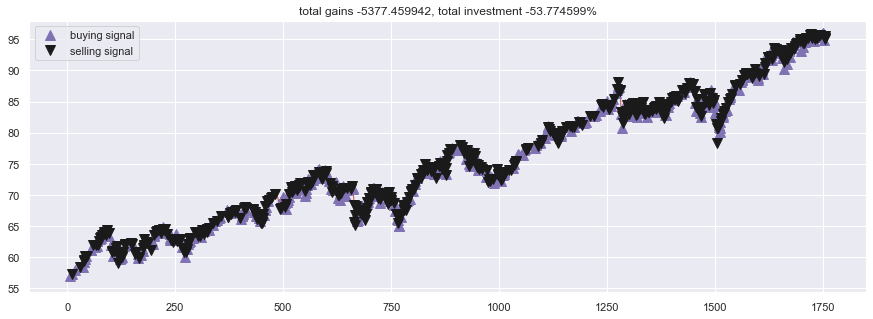

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()